In [1]:
import pandas as pd
import numpy as np

import re
#import pingouin as pg
#from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt
import sklearn.datasets

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [2]:
def drop_nn(df):
    df = df.select_dtypes(include=['number'])
    return df

### Clean dataframe

In [3]:
df = pd.read_csv("../../input/clean_data/IPIP_20_test.csv").drop(columns=['Unnamed: 0'])
df.index= df.index+1
df.shape

(7318, 300)

In [5]:
df.shape

(7318, 300)

In [4]:
info = pd.read_csv("../../input/clean_data/IPIP_20_desc_item.csv").drop(columns=['Unnamed: 0']).set_index('item#')
info.head(3)

,Item,Sign,Key,Dimension,Facet
item#,,,,,
i1,Worry about things.,+N1,N1,Neuroticism,Anxiety
i2,Make friends easily.,+E1,E1,Extraversion,Friendliness
i3,Have a vivid imagination.,+O1,O1,Openness,Imagination


## Factorial analysis

- Verify if a factorial analysis can be performed by **Bartlett’s test of sphericity** and **Kaiser-Meyer-Olkin (KMO)**

In [6]:
def perform_fa(df):
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    if p_value > 0.05:
        print(f"P-value=({p_value}). Statistically insignifincant, factorial analaisis can not be performed")
    else:
        print(f"P-value=({p_value}). Statistically significant, factorial analaisis can be performed")

In [7]:
perform_fa(df)

P-value=(0.0). Statistically significant, factorial analaisis can be performed


In [8]:
def perform_fa_KMO(df):
    kmo_all,kmo_model=calculate_kmo(df)
    if kmo_model < 0.6:
        print(f"KMO=({kmo_model}). Proportion of variance NOT suitable for factor analysis")
    else:
        print(f"KMO=({kmo_model}). Proportion of variance suitable for factor analysis")

In [9]:
perform_fa_KMO(df)

/usr/local/lib/python3.7/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


KMO=(0.9742421861895908). Proportion of variance suitable for factor analysis


- Choosing Number of factors by **Kaiser criterion**

In [10]:
def show_num_factors(df):
    fa = FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,method='minres', n_factors=10,
                        rotation='varimax', rotation_kwargs={},use_smc=True)
    fa.fit(df)
    ev, v = fa.get_eigenvalues()
    num_f = len([e for e in ev if e > ev.mean() + 2 * ev.std()])
    res_f = len([e for e in ev if e > 1])
    plt.scatter(range(1,df.shape[1]+1),ev)
    plt.plot(range(1,df.shape[1]+1),ev)
    plt.title('Scree Plot')
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    plt.grid()
    plt.show()
    return f"Best number of factors: {num_f}. Other possible factors {res_f-num_f}"

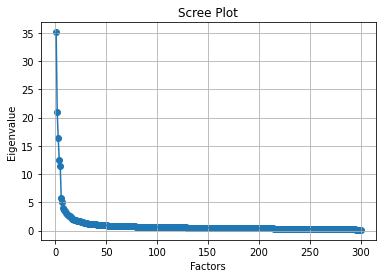

'Best number of factors: 5. Other possible factors 39'

In [11]:
show_num_factors(df)

In [12]:
def best_num_factors(df):
    fa = FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,method='minres', n_factors=10,
                        rotation=None, rotation_kwargs={},use_smc=True)
    fa.fit(df)
    ev, v = fa.get_eigenvalues()
    num_f = len([e for e in ev if e > ev.mean() + 2 * ev.std()])
    return num_f

In [13]:
def num_factors(df):
    fa = FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,method='minres', n_factors=10,
                        rotation=None, rotation_kwargs={},use_smc=True)
    fa.fit(df)
    ev, v = fa.get_eigenvalues()
    res_f = len([e for e in ev if e > 1])
    return res_f

In [14]:
n_fac = best_num_factors(df)

###  Performing Factorial Analysis

#### Analize test:
- To get item correlation with all the **Dimensions**

In [15]:
def fac_an(df, n_factors, name):
    drop_nn(df)
    fa = FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,method='minres', 
                         n_factors=n_factors, rotation='varimax', rotation_kwargs={},use_smc=True)
    fa.fit(df)
    load = pd.DataFrame.from_records(fa.loadings_, columns=([f'{name}'+str(i+1) for i in range(n_factors)]))
    load['item#']= df.columns
    return load

In [16]:
f_an_t = fac_an(df, n_fac, 'dimension')
f_an_t.head(3)

,dimension1,dimension2,dimension3,dimension4,dimension5,item#
0,0.598490,-0.125986,0.106546,0.071941,-0.019155,i1
1,-0.111008,0.607184,0.123381,0.232628,-0.050933,i2
2,0.045407,0.150988,-0.063756,0.016246,0.452346,i3


##### --> Include results in info dataframe

In [17]:
def item_corr(df, name):
    lis = drop_nn(df).idxmax(axis=1)
    #lis = [e.idxmax() if e.max() >= 0.3 else f'{e.idxmax()} saturation < 0.3' for i,e in drop_nn(f_an_t).iterrows()]
    datf = pd.DataFrame()
    datf['item#'] = df['item#'].to_numpy()
    datf[name] = lis
    return datf.set_index('item#')

In [18]:
def low_saturation(an_df):
    it_lis = []
    dim_lis = []
    for i,e in drop_nn(an_df).iterrows():
        if e.max() <= 0.3:
            it_lis.append(an_df.iloc[i]['item#'])
            dim_lis.append(f'{e.idxmax()} saturation < 0.3')
    datf = pd.DataFrame()
    datf['item#'] = it_lis
    datf['low_sat'] = dim_lis
    return datf.set_index('item#')

In [19]:
dim_info = item_corr(f_an_t, 'f_dimension')
dim_info.head(3)

,f_dimension
item#,
i1,dimension1
i2,dimension2
i3,dimension5


In [20]:
def add_info(info_df, df):
    tot = info_df.merge(df, left_index=True, right_index=True, how='outer')
    return tot

In [21]:
infoD = add_info(info, dim_info)
infoD.head(3)

,Item,Sign,Key,Dimension,Facet,f_dimension
item#,,,,,,
i1,Worry about things.,+N1,N1,Neuroticism,Anxiety,dimension1
i2,Make friends easily.,+E1,E1,Extraversion,Friendliness,dimension2
i3,Have a vivid imagination.,+O1,O1,Openness,Imagination,dimension5


#### Analize dimensions:
- To get item correlation with all the **Facets**

In [22]:
def fac_corr_df(df, dfv, dfv_col):
    lis = []
    dfv = drop_nn(dfv)
    df = drop_nn(df)
    for e in range(len(dfv)):
        if dfv.iloc[e][dfv_col] == dfv.iloc[e].max():
            lis.append('i'+str(e+1))
    return df[lis]

Create a df with all the items for each dimension

In [23]:
cols = list(drop_nn(f_an_t).columns)

In [24]:
df_f = {i:fac_corr_df(df, f_an_t, f"{i}") for i in cols}

In [25]:
df_f['dimension1'].head(3)

,i1,i6,i11,i13,i16,i21,i26,i31,i36,i41,...,i251,i253,i256,i261,i266,i271,i276,i281,i286,i296
1,5,2,1,5,2,2,1,3,4,4,...,2,2,4,1,1,1,2,5,2,1
2,5,2,5,5,5,5,5,5,4,5,...,5,5,5,1,5,5,2,5,5,5
3,4,4,2,4,1,2,1,1,4,1,...,1,5,4,2,2,2,4,2,1,4


#### Analize facets of each diemsion:

Get the best factors for each df:

In [26]:
#for e in list(drop_nn(fat).columns):
#    print(show_num_factors(fad[e]))

In [27]:
#n_dim_factors = {i:num_factors(df_f[i]) for i in cols}

Do the FA for all of the factors dfs:

In [28]:
f_an_f = {i:fac_an(df_f[i], 6, f"{i}_facet") for i in cols}

In [29]:
f_an_f['dimension3'].head(3)

,dimension3_facet1,dimension3_facet2,dimension3_facet3,dimension3_facet4,dimension3_facet5,dimension3_facet6,item#
0,0.543286,0.161568,0.191453,0.170504,0.124714,0.004469,i5
1,0.133528,0.611070,0.096178,0.305957,0.028086,-0.200523,i10
2,0.018957,0.231420,0.158054,0.687265,0.017696,-0.037353,i15


Add the info to the data frame

In [30]:
infoF = {i:item_corr(f_an_f[i], f'facet_{i}'[:-1]) for i in list(drop_nn(f_an_t).columns)}

In [31]:
infoF['dimension1'].head(3)

,facet_dimension
item#,
i1,dimension1_facet3
i6,dimension1_facet2
i11,dimension1_facet5


In [32]:
infoDF = infoD
for e in cols:
    infoDF = add_info(infoDF, infoF[e]).fillna('')

In [33]:
infoDF.head()

,Item,Sign,Key,Dimension,Facet,f_dimension,facet_dimension_x,facet_dimension_y,facet_dimension_x,facet_dimension_y,facet_dimension
item#,,,,,,,,,,,
i1,Worry about things.,+N1,N1,Neuroticism,Anxiety,dimension1,dimension1_facet3,,,,
i10,Like order.,+C2,C2,Conscientiousness,Orderliness,dimension3,,,dimension3_facet2,,
i100,Love order and regularity.,+C2,C2,Conscientiousness,Orderliness,dimension3,,,dimension3_facet2,,
i101,Have a low opinion of myself.,+N3,N3,Neuroticism,Depression,dimension1,dimension1_facet4,,,,
i102,Seek to influence others.,+E3,E3,Extraversion,Assertiveness,dimension2,,dimension2_facet3,,,


# DON'T RUN THIS CELL 
=====================================

In [34]:
infoDF['f_facet'] = infoDF.filter(regex=("facet_")).apply(lambda x: ''.join(x.astype(str)), axis=1
                                                           )#.apply(lambda x: x.split('_')[1])

=====================================
# DON'T RUN THIS CELL 

In [35]:
infoDF = infoDF.drop(infoDF.filter(regex=("facet_")), axis=1)

In [36]:
infoDF.head(3)

,Item,Sign,Key,Dimension,Facet,f_dimension,f_facet
item#,,,,,,,
i1,Worry about things.,+N1,N1,Neuroticism,Anxiety,dimension1,dimension1_facet3
i10,Like order.,+C2,C2,Conscientiousness,Orderliness,dimension3,dimension3_facet2
i100,Love order and regularity.,+C2,C2,Conscientiousness,Orderliness,dimension3,dimension3_facet2


In [38]:
#infoDF.to_csv("../../data/clean_data/IPIP_300_AN.csv")

Get low saturation items

In [22]:
low_sat_dim = low_saturation(f_an_t)
low_sat_dim.head(3)

,low_sat
item#,
i18,dimension2 saturation < 0.3
i21,dimension1 saturation < 0.3
i24,dimension4 saturation < 0.3


Get los saturation items for each factor

In [51]:
low_sat_fac = {i:low_saturation(f_an_f[i]) for i in cols}

In [52]:
low_sat_fac['dimension3']

,low_sat
item#,
i30,dimension3_facet1 saturation < 0.3
i75,dimension3_facet2 saturation < 0.3
i90,dimension3_facet1 saturation < 0.3


Include low saturation info in DF

In [43]:
infoDFF = add_info(infoDF, low_sat_dim).fillna('')

In [44]:
for e in cols:
    infoDFF = add_info(infoDFF, low_sat_fac[e]).fillna('')

In [45]:
infoDFF.head(3)

,Item,Sign,Key,Dimension,Facet,f_dimension,f_facet,low_sat_x,low_sat_y,low_sat_x,low_sat_y,low_sat_x,low_sat_y
item#,,,,,,,,,,,,,
i1,Worry about things.,+N1,N1,Neuroticism,Anxiety,dimension1,dimension1_facet7,,,,,,
i10,Like order.,+C2,C2,Conscientiousness,Orderliness,dimension3,dimension3_facet3,,,,,,
i100,Love order and regularity.,+C2,C2,Conscientiousness,Orderliness,dimension3,dimension3_facet3,,,,,,


In [46]:
infoDFF['low_satF'] = infoDF.filter(regex=("low_sat")).apply(lambda x: ''.join(x.astype(str)), axis=1
                                                           )#.apply(lambda x: x.split('_')[1])

In [47]:
infoDFF = infoDFF.drop(infoDF.filter(regex=("low_sat_")), axis=1)

In [48]:
infoDFF

,Item,Sign,Key,Dimension,Facet,f_dimension,f_facet,low_sat_x,low_sat_y,low_sat_x,low_sat_y,low_sat_x,low_sat_y,low_satF
item#,,,,,,,,,,,,,,
i1,Worry about things.,+N1,N1,Neuroticism,Anxiety,dimension1,dimension1_facet7,,,,,,,
i10,Like order.,+C2,C2,Conscientiousness,Orderliness,dimension3,dimension3_facet3,,,,,,,
i100,Love order and regularity.,+C2,C2,Conscientiousness,Orderliness,dimension3,dimension3_facet3,,,,,,,
i101,Have a low opinion of myself.,+N3,N3,Neuroticism,Depression,dimension1,dimension1_facet5,,,,,,,
i102,Seek to influence others.,+E3,E3,Extraversion,Assertiveness,dimension2,dimension2_facet3,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
i95,Am sure of my ground.,+C1,C1,Conscientiousness,Self-Efficacy,dimension3,dimension3_facet1,,,,,,,
i96,Am often in a bad mood.,+N2,N2,Neuroticism,Anger,dimension1,dimension1_facet2,,,,,,,
i97,Involve others in what I am doing.,+E2,E2,Extraversion,Gregariousness,dimension2,dimension2_facet1,,,,,,,
